# Linkit Beginner Challenge: Explainable Machine Learning using SHAP

SHAP (**SH**apley **A**dditive ex**P**lanations) can be used to interpret any model, i.e. it is **model-agnostic**.
It is not necessary to fully understand the math behind SHAP, because this can get quite complex. For us, it is enough to understand how we can use them to explain machine learning models.

You can read more on SHAP in the [original paper](https://arxiv.org/abs/1705.07874) or on several tutorials like this [beginner intro](https://www.kaggle.com/code/dansbecker/shap-values) to shap values and the [advanced use cases tutorial](https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values/tutorial)

## Your Task

Your task is to (1) train a classifier and (2) explain the classifier's predictions with shap values

Your submission we will be evaluated on the Accuracy of the classifer, as well as how well the explanation fit to the actual value.
For this, a few selected test points are held aside, for which you do not know the true values.


In [1]:
# download data and install dependencies if the notebook is running in google colab
try:
    import google.colab

    %pip install -q dvc shap
    !dvc get https://github.com/MoritzM00/Linkit-Beginner-Challenge-Explainable-ML data/bank_train.csv -o data/bank_train.csv
    !dvc get https://github.com/MoritzM00/Linkit-Beginner-Challenge-Explainable-ML data/bank_test.csv -o data/bank_test.csv
    IN_COLAB = True
except:
    IN_COLAB = False

In [1]:
import os
from typing import Optional
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    OrdinalEncoder,
)
from sklearn.metrics import classification_report, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier

shap.initjs()

In [2]:
TRAIN_PATH = os.path.join("data", "bank_train.csv")
TEST_PATH = os.path.join("data", "bank_test.csv")

## Data exploration

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,deposit
0,39,technician,single,secondary,no,0,yes,no,cellular,7,may,1,-1,0,no
1,30,technician,divorced,secondary,no,789,yes,no,cellular,12,may,1,-1,0,no
2,50,unemployed,married,primary,no,705,no,no,cellular,5,jun,1,-1,0,yes
3,51,management,married,tertiary,no,2635,no,no,cellular,21,may,3,74,5,yes
4,34,technician,single,tertiary,no,6529,no,no,cellular,14,aug,2,-1,0,yes


In [4]:
print(f"Shape of train data: {train.shape}")
print(f"Shape of test data: {test.shape}")  # test set does not include target column

Shape of train data: (8929, 15)
Shape of test data: (2233, 14)


In [5]:
TARGET = "deposit"

## Attributes Description <br>

###  Bank client data:<br>
<a id="bank_client_data"></a>
1 - **age:** (numeric)<br>
2 - **job:** type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - **marital:** marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - **education:** (categorical: primary, secondary, tertiary and unknown)<br>
5 - **default:** has credit in default? (categorical: 'no','yes','unknown')<br>
6 - **housing:** has housing loan? (categorical: 'no','yes','unknown')<br>
7 - **loan:** has personal loan? (categorical: 'no','yes','unknown')<br>
8 - **balance:** Balance of the individual.
### Related with the last contact of the current campaign:
<a id="last_contact"></a>
8 - **contact:** contact communication type (categorical: 'cellular','telephone') <br>
9 - **month:** last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - **day:** last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - dropped

### other attributes:<br>
<a id="other_attributes"></a>
12 - **campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)<br>
14 - **previous:** number of contacts performed before this campaign and for this client (numeric)<br>
15 - dropped

Output variable (desired target):<br>
21 - **deposit** - has the client subscribed a term deposit? (binary: 'yes','no')

<Axes: ylabel='count'>

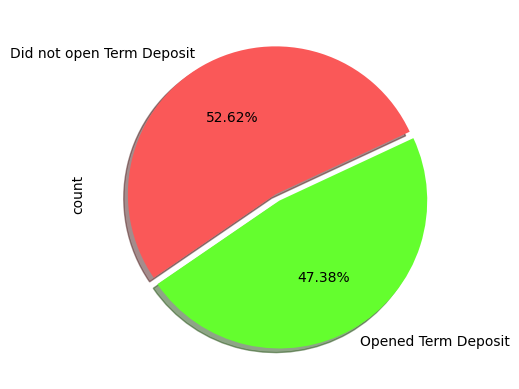

In [6]:
colors = ["#FA5858", "#64FE2E"]
labels = "Did not open Term Deposit", "Opened Term Deposit"
train[TARGET].value_counts().plot.pie(
    explode=[0, 0.05],
    autopct="%1.2f%%",
    shadow=True,
    startangle=25,
    colors=colors,
    labels=labels,
)

### What is a Term Deposit? 
A **Term deposit** is a deposit that a bank or a financial institurion offers with a fixed rate (often better than just opening deposit account) in which your money will be returned back at a specific maturity time. For more information with regards to Term Deposits please click on this link from Investopedia:  https://www.investopedia.com/terms/t/termdeposit.asp

## Data Preprocessing

We have categorical features, so we need to apply some encoding and also label encoding on the target.

In [7]:
X_display = train.drop(columns=TARGET, axis=1)  # for nicer shap visualizations
test_display = test.copy()


def encode_labels(df: pd.DataFrame, target_col: Optional[str] = None) -> pd.DataFrame:
    """Encode categorical labels in the dataframe with ordinal encoding.

    Parameters
    ----------
    df : pd.DataFrame
        The Dataframe to encode.
    target_col : Optional[str]
        Optionally, the target column to encode with Label Encoding.

    Returns
    -------
    pd.DataFrame
        The encoded dataframe.
    """
    df_encoded = df.copy()
    if target_col:
        df_encoded[target_col] = LabelEncoder().fit_transform(df[target_col])
    for col in df_encoded.select_dtypes("object").columns:
        values = df[col].values.reshape(-1, 1)  # sklearn expects 2D array
        df_encoded[col] = OrdinalEncoder(dtype=np.int64).fit_transform(values)
    return df_encoded

In [8]:
train = encode_labels(train, target_col=TARGET)
test = encode_labels(test)
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,deposit
0,39,9,2,1,0,0,1,0,0,7,8,1,-1,0,0
1,30,9,0,1,0,789,1,0,0,12,8,1,-1,0,0
2,50,10,1,0,0,705,0,0,0,5,6,1,-1,0,1
3,51,4,1,2,0,2635,0,0,0,21,8,3,74,5,1
4,34,9,2,2,0,6529,0,0,0,14,1,2,-1,0,1


## Model Selection

First, we need to split the data into a training and test set. We do this with the `train_test_split` function provided by `sklearn`.

Then, a simple `DecisionTreeClassifier` is fitted on the training set. 

In [9]:
X = train.drop(columns=TARGET, axis=1)
y = train[TARGET]

In [10]:
# 0.8/0.2 train/validation split with stratification and shuffling
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, shuffle=True, test_size=0.2
)

In [11]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
clf.score(X_train, y_train)

1.0

In [12]:
clf.score(X_val, y_val)

0.6080627099664053

We see that this classifier overfits a lot, because the score on the validation set is much lower. This is common with Decision trees with default parameters.

Feel free to change the classifier and its parameters or use hyper-parameter optimization frameworks like [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) or [Optuna](https://optuna.org/) or just the exhaustive Grid Search of `sklearn` (`sklearn.model_selection.GridSearchCV`) to improve on the classifier performance.

In [13]:
print(classification_report(y_val, clf.predict(X_val), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.63      0.61      0.62       940
         Yes       0.58      0.60      0.59       846

    accuracy                           0.61      1786
   macro avg       0.61      0.61      0.61      1786
weighted avg       0.61      0.61      0.61      1786



### Classification Metrics

**Precision**: When we predict a positive, how sure are we?
In our case, the precision is 0.6 for the positive class (deposit = yes), meaning that the classifier is 60% sure that a positive prediction is correct.

**Recall**: How many of the positive cases did we catch?
Here, the recall is 0.59, meaning that the classifier caught 59% of the positive cases.

*Note: As precision increases, recall decreases. This is known as the precision-recall tradeoff.*

**F1 Score**: The harmonic mean of precision and recall. It is a good measure of accuracy, as it takes both false positives and false negatives into account.

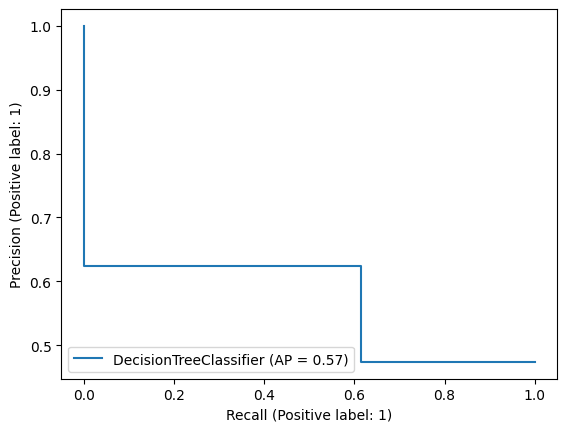

In [15]:
y_pred = clf.predict(X_val)
PrecisionRecallDisplay.from_predictions(y_val, y_pred, name="DecisionTreeClassifier")

## Explainable ML

### Global Feature Importance

The first plot is showing the mean absolute shap values for each feature. In order to test your feature importance measure you can add a noise variable that should have a very low impact to your model. A noise variable is independet of the target variable, but varies.

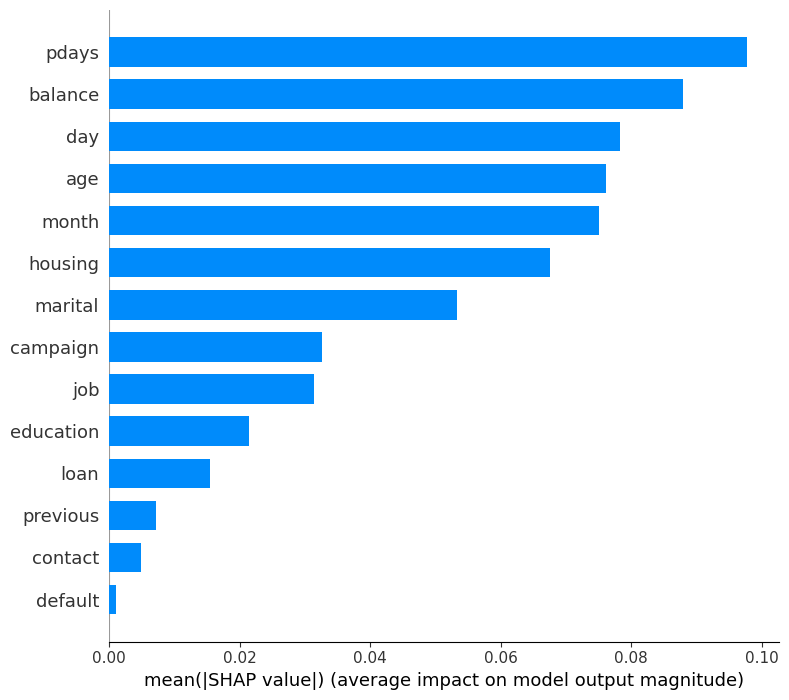

In [16]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)[1]
shap.summary_plot(shap_values, X, plot_type="bar")

### Local Feature Importance

Local feature importances look at single predictions. They try to explain how your model uses the input observation to get to the prediction. In the following we will see some individual shap values.

The following plot is called a beeswarm plot. It shows the shap values for *each sample* and *feature* represented by a dot in the beeswarm plot.

Each dot has three characteristics:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


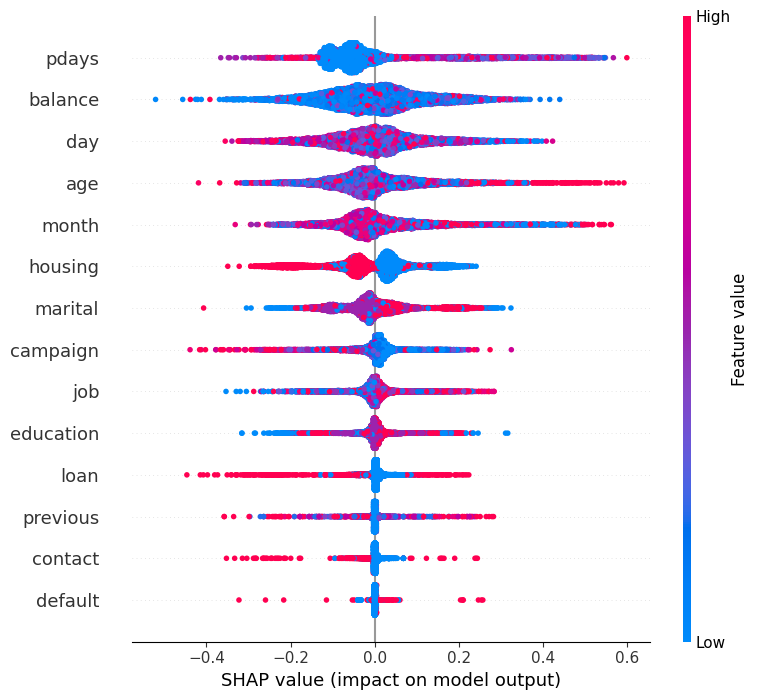

In [17]:
shap.summary_plot(shap_values, X)

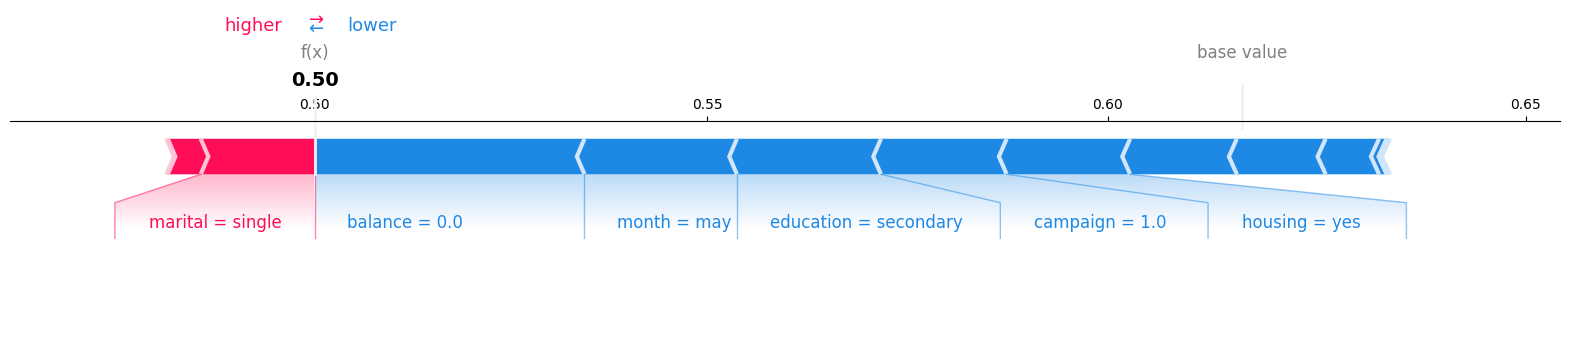

In [18]:
i = 0
shap.force_plot(
    explainer.expected_value[1],
    shap_values[i, :],
    X_display.iloc[i, :],
    link="logit",
    matplotlib=True,
)  # link=logit transforms the log-odds (raw output of the model) into probabilities

Play around with other plots provided by the `shap` library to display and leverage the informative value of shap values and to improve your understanding of the model.

### Your Turn: Explanation of three individual samples

Explain the following samples:
- Index 0 of the train set
- The first two rows of the **test** set

This will influence your final score in the challenge.

In [19]:
first = train.iloc[0]
second = test.iloc[0]
third = test.iloc[1]

In [20]:
# TODO: Explain the three samples
...

## Submission

To finalize your submission, you will have to run your model on the test set.
To do that, you will have to modify the following two cells accordingly.

After that you should have a file called `submission-<your_team_number>.csv`.

**Important**:
Make sure that your submitted notebook contains the outputs (do not clear the outputs before submitting!).

Then, send us the notebook and the csv file via email to <moritz.mistol@linkit.tech> with the subject `Submission - Team <your_team_number>`.

In [17]:
TEAM_NUMBER = 0  # TODO: Replace with your team number

In [18]:
def predict(X) -> np.ndarray:
    """Predict the target column for the given data.

    Parameters
    ----------
    X : pd.DataFrame
        The data to predict the target column for.

    Returns
    -------
    y_pred : np.ndarray
        The predicted target column.
    """
    # TODO: Implement your prediction logic here
    y_pred = clf.predict(X)
    return y_pred

The following cell calculates the predicted values for the set and saves them to a csv file.

In [19]:
y_pred = predict(test)
submission = pd.DataFrame({"id": test.index, "deposit": y_pred})
submission.to_csv(f"submission-{TEAM_NUMBER}.csv", index=False)